In [1]:
import cv2
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from FER_model import *
from torchvision import transforms
import torch.utils.data as utils
from sklearn.model_selection import train_test_split
from PIL import Image
from matplotlib import pyplot as plt

# GPU 자원 사용확인
devices_id = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(
    devices_id
)  # fix bug for `ERROR: all tensors must be on devices[0]`


In [2]:
fer_csv = '../data/FER+/fer2013.csv'

emotion_dict = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy',
                4: 'sad', 5: 'surprise', 6: 'neutral'}

# Step 1. Load Dataset
def load_fer2013(fer_csv):
    data = pd.read_csv(fer_csv)
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'), (48, 48))
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    emotions = data['emotion'].values
    return faces, emotions

# Step 1. Load Dataset
class EmotionDataset(utils.Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        x = self.X[index].reshape(48, 48)
        x = Image.fromarray((x))
        if self.transform is not None:
            x = self.transform(x)
        y = self.y[index]
        return x, y

# Step 1. Load Dataset
faces, emotions = load_fer2013(fer_csv)
# dataset 분할(train, validation)
train_X, val_X, train_y, val_y = train_test_split(faces, emotions, test_size=0.2, random_state = 1, shuffle=True)
avg_pixels = train_X.mean()
std_pixels = train_X.std()
# dataset augmentation
train_transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(), # defalt p = 0.5
                    transforms.RandomRotation(30),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=avg_pixels, std=std_pixels)
                    ])
val_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=avg_pixels, std=std_pixels)
                ])

# Step 1. Load Dataset
train_dataset = EmotionDataset(train_X, train_y, train_transform)
val_dataset = EmotionDataset(val_X, val_y, val_transform)

# Step 2. Make Dataset Iterable
batch_size = 100

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size)
validloader = torch.utils.data.DataLoader(val_dataset, batch_size)

129.41025

In [41]:
np.shape(train_X)

(28709, 48, 48, 1)

In [4]:
# 임의의 학습 이미지를 가져와서 텐서보드에 계산 그래프 추가
dataiter = iter(trainloader)
images, _ = dataiter.next()

In [29]:
sample_img = train_dataset.__getitem__(10)

In [30]:
trans = transforms.RandomRotation(30)

In [32]:
transed_img = trans(sample_img[0])
transed_img = transed_img[0].numpy()

In [33]:
img_np = sample_img[0][0].numpy()

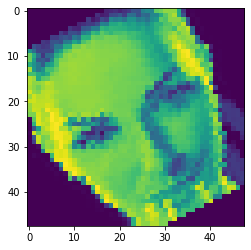

In [34]:
plt.imshow(img_np)

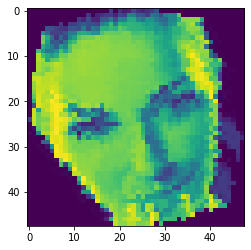

In [35]:
plt.imshow(transed_img)

In [3]:
# Step 3. Create Model Class ./FER_model.py
# Step 4. Instantiate Model Class
model = FER_CNN()
if devices_id == type([]):  # -> GPU
    model = nn.DataParallel(model, device_ids=devices_id).cuda()
else:
    model = nn.DataParallel(model, device_ids=[devices_id]).cuda()

# 임의의 학습 이미지를 가져와서 텐서보드에 계산 그래프 추가
dataiter = iter(train_loader)
images, _ = dataiter.next()

# Step 5. Instantiate Loss Class
criterion = torch.nn.CrossEntropyLoss()  # computes softmax and then the cross entropy
# Step 6. Instantiate Optimizer Class
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [4]:
# Step 7. Train Model
epochs = 300

loss = 0
total_iter = 0

for epoch in range(int(epochs)):
    iter = 0
    for i, (images, labels) in enumerate(trainloader):
        images = images.to(devices_id)
        labels = labels.to(devices_id)
        optimizer.zero_grad()

        outputs = model(images)
        # Calc loss
        loss = criterion(outputs, labels)
        # Back-propagation
        loss.backward()
        # Updating wegihts
        optimizer.step()

        total_iter += 1
        writer.add_scalar('Train/Loss', loss, total_iter)

        iter += 1
        if iter % 100 == 0:
            # calculate Accuracy
            correct = 0
            total = 0
            for images, labels in validloader:
                images = images.to(devices_id)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
                predicted = predicted.cpu()
                correct += (predicted == labels).sum()
            accuracy = 100 * correct / total
            print(
                f"[Epoch {epoch}] [Iteration: {i:03d}/{len(trainloader)}] [Loss: {loss.item():.3f}] [Accuracy: {accuracy:.2f}]"
            )

writer.close()

[Epoch 0] [Iteration: 099/288] [Loss: 1.793] [Accuracy: 25.09]
[Epoch 0] [Iteration: 199/288] [Loss: 1.788] [Accuracy: 27.56]
[Epoch 1] [Iteration: 099/288] [Loss: 1.639] [Accuracy: 35.90]
[Epoch 1] [Iteration: 199/288] [Loss: 1.685] [Accuracy: 36.92]
[Epoch 2] [Iteration: 099/288] [Loss: 1.570] [Accuracy: 39.13]
[Epoch 2] [Iteration: 199/288] [Loss: 1.636] [Accuracy: 41.15]
[Epoch 3] [Iteration: 099/288] [Loss: 1.644] [Accuracy: 42.35]
[Epoch 3] [Iteration: 199/288] [Loss: 1.661] [Accuracy: 43.01]
[Epoch 4] [Iteration: 099/288] [Loss: 1.384] [Accuracy: 44.50]
[Epoch 4] [Iteration: 199/288] [Loss: 1.529] [Accuracy: 44.89]
[Epoch 5] [Iteration: 099/288] [Loss: 1.392] [Accuracy: 46.59]
[Epoch 5] [Iteration: 199/288] [Loss: 1.441] [Accuracy: 46.52]
[Epoch 6] [Iteration: 099/288] [Loss: 1.384] [Accuracy: 47.37]
[Epoch 6] [Iteration: 199/288] [Loss: 1.522] [Accuracy: 47.31]
[Epoch 7] [Iteration: 099/288] [Loss: 1.366] [Accuracy: 48.62]
[Epoch 7] [Iteration: 199/288] [Loss: 1.585] [Accuracy: